# Pyspark Estimators

In this notebook, we'll work through the construction of our own Estimator in Pyspark. Estimators act on an input dataframe to yield a transformer instance. If you're unfamilar with transformers, please refer to my blog article and Notebook XXVII on that topic. Estimators form a key component to pipelines, where a series of estimators & transformers can be chained together to yield a complete machine learning workflow. 

Here the pipeline created will be designed to make use of a Linear Regressor to predict housing price values. We will make use of the **California Housing Prices** dataset. These data were briefly explored in Notebook XXVI, and as such I won't repeat that analysis here.

We can start by importing the necessary packages, and setting up our spark session:

In [1]:
import findspark
findspark.init("/opt/homebrew/Cellar/apache-spark/3.5.0/libexec")

In [2]:
from sklearn.datasets import fetch_california_housing
from typing import Any
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import keyword_only
from pyspark.sql import functions as F
from pyspark.sql import dataframe as DataFrame
from pyspark.ml import Estimator, Transformer, Pipeline 
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.param.shared import HasInputCols, HasOutputCols, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
spark = SparkSession.builder.appName("test").getOrCreate()

24/04/07 05:12:27 WARN Utils: Your hostname, Michaels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
24/04/07 05:12:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/07 05:12:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Dataset

Now let's obtain the data we will work with. A description of the data can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing

In [3]:
# obtain data
data = fetch_california_housing(as_frame=True)
dfX = data["data"]
sY = data["target"]

In [4]:
dfX.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Let's generate a box plot to visualize the distribution and scale for our input features:

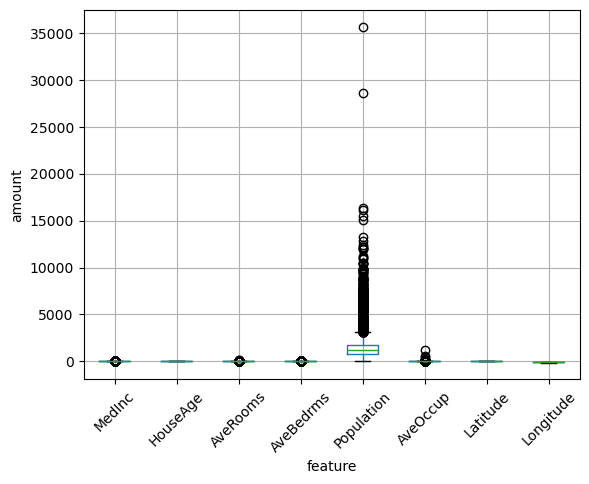

In [5]:
dfX.boxplot(column=dfX.columns.tolist(), rot=45)
plt.xlabel("feature")
plt.ylabel("amount")
plt.show()

Since we'll be using linear regression, these features should be standardized. Our task in this notebook will be to create an estimator to do just this! Our estimator will learn the parameters necessary to convert each input feature to have a mean of 0.0, and standard deviation of 1.0.

Before proceeding, let's place our data into a pyspark dataframe:

In [6]:
# package the data into a pyspark dataframe
dfX["MedianHouseValue"] = sY
df = spark.createDataFrame(dfX)
df.show(5)

+------+--------+------------------+------------------+----------+------------------+--------+---------+----------------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|MedianHouseValue|
+------+--------+------------------+------------------+----------+------------------+--------+---------+----------------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23|           4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22|           3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24|           3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25|           3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25|           3.422|
+------+--------+-------

## Custom Estimator

This implementation will come in two parts:
1. First, we need to build the transformer that will be returned by the estimator 
2. Second, we will implement the estimator to learn the correct parameters to perform standardization

Now that we know what needs to be done, let's build a new estimator *CustomStandardScaler* and transformer *CustomStandardScalerModel*:

In [13]:
class CustomStandardScalerModel(Transformer, HasInputCols, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable):
    """
    Class to apply learned parameters on a set of input features, in order to standardize them
    """
    means = Param(
        Params._dummy(),
        "means",
        "List of mean values for each input feature.",
        typeConverter=TypeConverters.toList,
    )
    stdevs = Param(
        Params._dummy(),
        "stdevs",
        "List of standard deviations for each input feature.",
        typeConverter=TypeConverters.toList,
    )
    
    @keyword_only
    def __init__(self,
                 inputCols: list=[],
                 outputCols: list=[],
                 means: list=[],
                 stdevs: list=[]) -> None:
        """
        Function to initialise the class instance
        """
        super().__init__()
        self._setDefault(inputCols=[], outputCols=[], means=[], stdevs=[])
        kwargs = self._input_kwargs
        self.set_params(**kwargs)
        
        # check the input lists have the same length
        if len(set([len(inputCols), len(outputCols), len(means), len(stdevs)])) != 1:
            raise ValueError("Input lists have non-matching length!")

    @keyword_only
    def set_params(self,
                   inputCols: list=[],
                   outputCols: list=[],
                   means: list=[],
                   stdevs: list=[]) -> None:
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def setMeans(self, new_means: list) -> Any:
        return self.setParams(means=new_means)

    def getMeans(self) -> list:
        return self.getOrDefault(self.means)

    def setStdevs(self, new_stdevs: list) -> Any:
        return self.setParams(stdevs=new_stdevs)

    def getStdevs(self) -> list:
        return self.getOrDefault(self.stdevs)

    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Function to standardize a set of input features in a dataframe
        """
        # read in the transformer parameters
        inputCols = self.getInputCols()
        outputCols = self.getOutputCols()
        means = self.getMeans()
        stdevs = self.getStdevs()

        # generate standardized output columns, and return
        for input_col, output_col, mean, stdev in zip(inputCols, outputCols, means, stdevs):
            df = df.withColumn(output_col, (F.col(input_col) - mean)/stdev)
        return df

In [23]:
class CustomStandardScaler(Estimator, HasInputCols, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable):
    """
    Class to learn parameters needed to standardize a set of input features
    """
    withMean = Param(
        Params._dummy(),
        "withMean",
        "Boolean to determine if standardizing will involve the mean.",
        typeConverter=TypeConverters.toBoolean,
    )
    withStd = Param(
        Params._dummy(),
        "withStd",
        "Boolean to determine if standardizing will involve the standard deviation.",
        typeConverter=TypeConverters.toBoolean,
    )
    
    @keyword_only
    def __init__(self,
                 inputCols: list=[],
                 outputCols: list=[],
                 withMean: bool=True,
                 withStd: bool=True) -> None:
        """
        Function to initialise the class instance
        """
        super().__init__()
        self._setDefault(inputCols=[], outputCols=[], withMean=True, withStd=True)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)
        
        # check the input lists have the same length
        if len(inputCols) != len(outputCols):
            raise ValueError("Input and output columns have non-matching length!")

    @keyword_only
    def set_params(self,
                   inputCols: list=[],
                   outputCols: list=[],
                   withMean: bool=True,
                   withStd: bool=True) -> None:
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def setWithMean(self, new_withMean: bool) -> Any:
        return self.setParams(withMean=new_withMean)

    def getWithMean(self) -> bool:
        return self.getOrDefault(self.withMean)

    def setWithStd(self, new_withStd: bool) -> Any:
        return self.setParams(withStd=new_withStd)

    def getWithStd(self) -> bool:
        return self.getOrDefault(self.withStd)

    def _fit(self, df: DataFrame) -> CustomStandardScalerModel:
        """
        Function to learn the standardizing parameters
        """
        # read in the estimator parameters
        inputCols = self.getInputCols()
        outputCols = self.getOutputCols()
        withMean = self.getWithMean()
        withStd = self.getWithStd()

        # compute means
        if withMean:
            means = [df.select(F.mean(col)).collect()[0][0] for col in inputCols]
        else:
            means  = [0.0 for col in inputCols]

        # compute standard deviations
        if withStd:
            stdevs = [df.select(F.std(col)).collect()[0][0] for col in inputCols]
        else:
            stdevs = [1.0 for col in inputCols]

        # return transformer
        return CustomStandardScalerModel(inputCols=inputCols, outputCols=outputCols, means=means, stdevs=stdevs)

We can now test out our estimator & transformer to verify that they work:

In [17]:
# prepare input columns list
input_columns = df.columns
input_columns.remove("MedianHouseValue")

In [19]:
# prepare output columns list
output_columns = [col + "_s" for col in input_columns]

In [24]:
scalar = CustomStandardScaler(inputCols=input_columns, outputCols=output_columns, withMean=True, withStd=True)

In [25]:
scalar_model = scalar.fit(df)

In [26]:
# check our learned means
scalar_model.getMeans()

[3.8706710029069753,
 28.639486434108527,
 5.428999742190377,
 1.0966751496062066,
 1425.4767441860465,
 3.070655159436372,
 35.6318614341085,
 -119.56970445736444]

In [27]:
# check our learned standard deviations
scalar_model.getStdevs()

[1.899821717945268,
 12.585557612111646,
 2.474173139424319,
 0.4739108567954659,
 1132.4621217653414,
 10.386049562213614,
 2.135952397457123,
 2.0035317235025847]

In [28]:
df = scalar_model.transform(df)

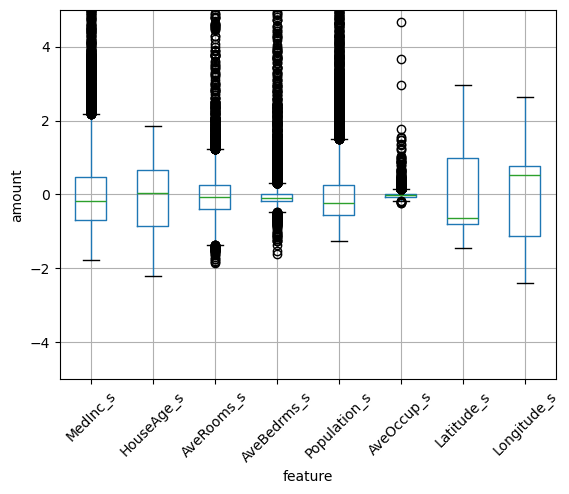

In [31]:
# plot the standardized features
dfP = df.select(output_columns).toPandas()
ax = dfP.boxplot(column=dfP.columns.tolist(), rot=45)
ax.set_ylim(-5, 5)
plt.xlabel("feature")
plt.ylabel("amount")
plt.show()

We can see that our custom standard scaler has transformed our data, such that all the features exist at similar scales. It is important to note that differences do persist between the features, however (i.e. number and distribution of outliers, range of quartiles, etc). Nevertheless, these results are exactly what we would expect from standardization (refer to Notebook XXVI on Pyspark Pipelines).

## Using our Estimator in a Pipeline

The strength of writing our own estimators comes when applying them within a machine learning pipeline. Here we'll now incorporate the class we wrote above into a pipeline for modelling our data.

In [32]:
# perform a train-test split
dfTrain, dfTest = df.randomSplit([0.8,0.2])
print(f"Total number of samples in dataset: {df.count()}, training samples: {dfTrain.count()}, testing samples: {dfTest.count()}")

Total number of samples in dataset: 20640, training samples: 16463, testing samples: 4177


In [33]:
# define the pipeline
pipeline = Pipeline(stages=[
    CustomStandardScaler(inputCols=input_columns, outputCols=output_columns),
    VectorAssembler(inputCols = output_columns, outputCol="Features"),
    LinearRegression(featuresCol = 'Features', labelCol = 'MedianHouseValue', regParam = 0.01)
])

In [34]:
# train the pipeline
model = pipeline.fit(dfTrain)

24/04/07 06:13:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/07 06:13:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [35]:
# make predictions on the test set
dfPred = model.transform(dfTest)

In [36]:
dfPred.select("MedianHouseValue","prediction").show(5)

+----------------+------------------+
|MedianHouseValue|        prediction|
+----------------+------------------+
|           1.042| 1.057177511489855|
|           0.952|1.3018628997662158|
|           1.625| 1.316618183921713|
|           1.625|1.0314613645717672|
|           0.518| 0.580490555068186|
+----------------+------------------+
only showing top 5 rows



In [37]:
n_samples = dfPred.count()
dfPred.select( (1/n_samples * F.sum(F.pow(F.col("MedianHouseValue") - F.col("prediction"),2))).alias("MSE") ).show()

+------------------+
|               MSE|
+------------------+
|0.5190910966689919|
+------------------+



It is evident that the pipeline model is working correctly.

Another nice benefit of pipelines is that we can save our entire workflow, for use at a later time. To save our current pipeline:

In [38]:
# write the trained model to disk
model.write().overwrite().save("./trained_pipeline")

In [39]:
# load the saved model, and confirm it works
model2 = PipelineModel.load("./trained_pipeline")

In [40]:
dfPred = model2.transform(dfTest)
dfPred.select("MedianHouseValue","prediction").show(5)

+----------------+------------------+
|MedianHouseValue|        prediction|
+----------------+------------------+
|           1.042| 1.057177511489855|
|           0.952|1.3018628997662158|
|           1.625| 1.316618183921713|
|           1.625|1.0314613645717672|
|           0.518| 0.580490555068186|
+----------------+------------------+
only showing top 5 rows



This result is exactly the same as that obtained earlier above.

In [42]:
spark.stop()